Setup


In [13]:
 !pip install -q pandas scikit-learn aif360
 !apt-get install -y -qq libatlas-base-dev  # speeds up some numeric ops

import warnings
warnings.filterwarnings("ignore")  # Keep the output tidy for beginners

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# AIF360 imports for fairness data structures, metrics, and mitigation
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

# For reproducibility
SEED = 42
np.random.seed(SEED)



 Load & Prepare Data

In [14]:


# 1) Load the Pima Indians Diabetes dataset from a public URL
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
           'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

data = pd.read_csv(url, names=columns)

print("Rows, Columns:", data.shape)
data.head()



Rows, Columns: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Features, Target, and Sensitive Attribute


In [15]:

# 2) Split into features (X) and target (y)
X = data.drop('Outcome', axis=1).copy()
y = data['Outcome'].copy()

# 3) Create a simple sensitive attribute:
#    We'll treat Age >= 30 as Privileged (1), Age < 30 as Unprivileged (0)
X['Age_group'] = (X['Age'] >= 30).astype(int)

# 4) Train-Test split (keep class balance with stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Train size:", X_train.shape[0], " Test size:", X_test.shape[0])


Train size: 614  Test size: 154


Scale Numeric Features (Not the Sensitive Attribute)


In [16]:

# We'll scale only the numeric features (exclude Age_group)
numeric_features = X_train.columns.drop('Age_group')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled  = scaler.transform(X_test[numeric_features])

# Rebuild dataframes with scaled features + Age_group
X_train_proc = pd.DataFrame(X_train_scaled, columns=numeric_features)
X_train_proc['Age_group'] = X_train['Age_group'].values

X_test_proc = pd.DataFrame(X_test_scaled, columns=numeric_features)
X_test_proc['Age_group'] = X_test['Age_group'].values

X_train_proc.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Age_group
0,-0.851355,-0.980131,-0.404784,-0.553973,-0.331319,-0.607678,0.310794,-0.792169,0
1,0.356576,0.161444,0.465368,0.392787,-0.526398,-0.302139,-0.116439,0.561034,1
2,-0.549372,-0.504474,-0.622322,1.213312,0.142444,0.372594,-0.764862,-0.707594,0
3,-0.851355,0.795653,-0.731091,-1.311380,-0.730766,-0.289408,0.262314,-0.369293,0
4,-1.153338,-0.821579,-0.296015,1.150195,0.244628,1.607482,-0.337630,-0.961320,0


Build AIF360 Datasets (Required for Fairness Metrics)

In [18]:

# AIF360 BinaryLabelDataset wraps our data so we can compute fairness metrics easily
train_bld = BinaryLabelDataset(
    df=pd.concat([X_train_proc, y_train.reset_index(drop=True)], axis=1),
    label_names=['Outcome'],
    protected_attribute_names=['Age_group']  # our sensitive attribute
)

test_bld = BinaryLabelDataset(
    df=pd.concat([X_test_proc, y_test.reset_index(drop=True)], axis=1),
    label_names=['Outcome'],
    protected_attribute_names=['Age_group']
)

# Quick sanity check: row counts match
assert len(train_bld.features) == len(X_train), "Train dataset mismatch!"
assert len(test_bld.features) == len(X_test), "Test dataset mismatch!"
print("AIF360 datasets ready")


AIF360 datasets ready


Helper Functions (Simple, Readable Outputs)

In [19]:

def show_dataset_fairness(bld, title="Dataset Fairness"):
    """
    Shows base rate (how often Outcome=1 happens) in each group and Disparate Impact.
    Disparate Impact = (positive rate in unprivileged) / (positive rate in privileged)
    Closer to 1.0 is more fair (common rule-of-thumb threshold: >= 0.8).
    """
    metric = BinaryLabelDatasetMetric(
        bld,
        unprivileged_groups=[{'Age_group': 0}],
        privileged_groups=[{'Age_group': 1}]
    )
    print(f"\n=== {title} ===")
    print(f"Base rate (Unprivileged: Age<30): {metric.base_rate(privileged=False):.3f}")
    print(f"Base rate (Privileged:   Age≥30): {metric.base_rate(privileged=True):.3f}")
    print(f"Disparate Impact (Unpriv/Priv):   {metric.disparate_impact():.3f}")

def show_model_fairness(test_bld_true, y_pred_labels, title="Model Fairness on Test"):
    """
    Uses AIF360 ClassificationMetric to show fairness on predictions.
    - SPD (Statistical Parity Difference): closer to 0 is better
    - EOD (Equal Opportunity Difference): closer to 0 is better
    - AOD (Average Odds Difference): closer to 0 is better
    """
    pred_bld = test_bld_true.copy()
    pred_bld.labels = np.array(y_pred_labels).reshape(-1, 1)

    cm = ClassificationMetric(
        test_bld_true, pred_bld,
        unprivileged_groups=[{'Age_group': 0}],
        privileged_groups=[{'Age_group': 1}]
    )

    acc = accuracy_score(test_bld_true.labels, y_pred_labels)
    print(f"\n=== {title} ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"Statistical Parity Difference (SPD): {cm.statistical_parity_difference():.3f}")
    print(f"Equal Opportunity Difference (EOD):  {cm.equal_opportunity_difference():.3f}")
    print(f"Average Odds Difference (AOD):       {cm.average_odds_difference():.3f}")

def show_group_confusion(test_bld_true, y_pred_labels, group_attr='Age_group'):
    """
    Shows confusion matrix pieces (TP, FP, TN, FN) for each group.
    Helps students understand where mistakes happen more.
    """
    pred_bld = test_bld_true.copy()
    pred_bld.labels = np.array(y_pred_labels).reshape(-1, 1)
    idx = test_bld_true.feature_names.index(group_attr)

    print("\n--- Per-Group Confusion ---")
    for value, name in [(0, "Unprivileged (Age<30)"), (1, "Privileged (Age≥30)")]:
        mask = (test_bld_true.features[:, idx] == value)
        y_true_g = test_bld_true.labels[mask].ravel()
        y_pred_g = pred_bld.labels[mask].ravel()
        tn, fp, fn, tp = confusion_matrix(y_true_g, y_pred_g).ravel()


Train a Simple Baseline Model

In [20]:

# Train a basic Logistic Regression model (beginner-friendly and fast)
baseline = LogisticRegression(random_state=SEED)
baseline.fit(X_train_proc.drop('Age_group', axis=1), y_train)

# Predictions + a useful score (probabilities) for future extensions
y_pred_base = baseline.predict(X_test_proc.drop('Age_group', axis=1))
y_prob_base = baseline.predict_proba(X_test_proc.drop('Age_group', axis=1))[:, 1]

# Report performance + fairness
print(f"Baseline Accuracy: {accuracy_score(y_test, y_pred_base):.3f}")
print(f"Baseline ROC-AUC: {roc_auc_score(y_test, y_prob_base):.3f}")

show_dataset_fairness(train_bld, title="Train Set Fairness (Base Rates)")
show_model_fairness(test_bld, y_pred_base, title="Baseline Model Fairness (Test)")
show_group_confusion(test_bld, y_pred_base)


Baseline Accuracy: 0.714
Baseline ROC-AUC: 0.823

=== Train Set Fairness (Base Rates) ===
Base rate (Unprivileged: Age<30): 0.219
Base rate (Privileged:   Age≥30): 0.482
Disparate Impact (Unpriv/Priv):   0.454

=== Baseline Model Fairness (Test) ===
Accuracy: 0.714
Statistical Parity Difference (SPD): -0.299
Equal Opportunity Difference (EOD):  -0.115
Average Odds Difference (AOD):       -0.184

--- Per-Group Confusion ---


If Disparate Impact is far below 0.8, the unprivileged group is getting fewer positive outcomes.


If SPD/EOD/AOD are far from 0, the model predictions are less fair.

Apply Bias Mitigation: Reweighing (AIF360)

In [21]:

# Reweighing adds instance weights to make the training data more balanced between groups.
rw = Reweighing(
    unprivileged_groups=[{'Age_group': 0}],
    privileged_groups=[{'Age_group': 1}]
)
rw.fit(train_bld)
train_bld_rw = rw.transform(train_bld)

# Train the same model again, but now use the instance weights
model_rw = LogisticRegression(random_state=SEED)
model_rw.fit(
    X_train_proc.drop('Age_group', axis=1),
    y_train,
    sample_weight=train_bld_rw.instance_weights  # <-- key AIF360 step
)

# Predict again with the debiased model
y_pred_rw = model_rw.predict(X_test_proc.drop('Age_group', axis=1))
y_prob_rw = model_rw.predict_proba(X_test_proc.drop('Age_group', axis=1))[:, 1]

# Show results in the same format for easy comparison
print(f"Reweighing Accuracy: {accuracy_score(y_test, y_pred_rw):.3f}")
print(f"Reweighing ROC-AUC: {roc_auc_score(y_test, y_prob_rw):.3f}")

show_model_fairness(test_bld, y_pred_rw, title="Reweighing Model Fairness (Test)")
show_group_confusion(test_bld, y_pred_rw)


Reweighing Accuracy: 0.708
Reweighing ROC-AUC: 0.803

=== Reweighing Model Fairness (Test) ===
Accuracy: 0.708
Statistical Parity Difference (SPD): -0.177
Equal Opportunity Difference (EOD):  -0.062
Average Odds Difference (AOD):       -0.072

--- Per-Group Confusion ---


📊 Simple comparison chart (Baseline vs Reweighing)

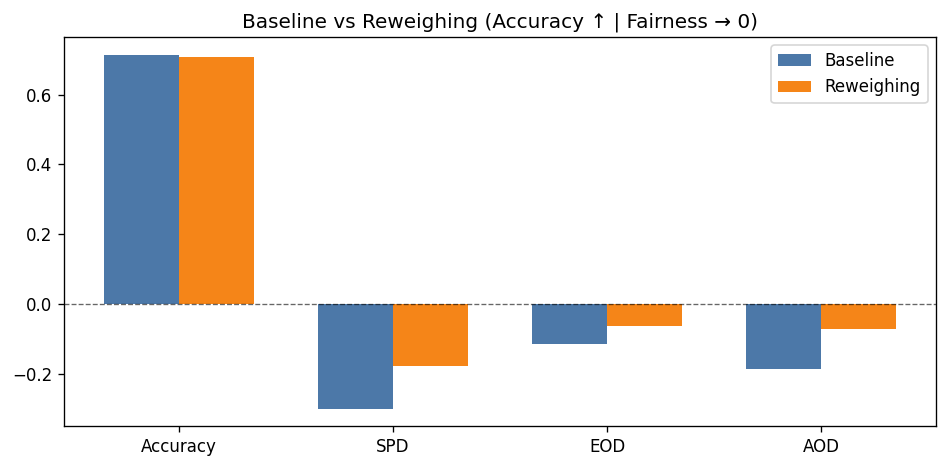

,Baseline,Reweighing
Accuracy,0.7143,0.7078
SPD,-0.2991,-0.1768
EOD,-0.1151,-0.0625
AOD,-0.1843,-0.0717


In [22]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from aif360.metrics import ClassificationMetric

# Helper to compute accuracy + fairness metrics in one go
def get_metrics(test_bld_true, y_pred):
    pred_bld = test_bld_true.copy()
    pred_bld.labels = np.array(y_pred).reshape(-1, 1)
    cm = ClassificationMetric(
        test_bld_true, pred_bld,
        unprivileged_groups=[{'Age_group': 0}],
        privileged_groups=[{'Age_group': 1}]
    )
    return {
        "Accuracy": accuracy_score(test_bld_true.labels, y_pred),
        "SPD": cm.statistical_parity_difference(),       # closer to 0 is better
        "EOD": cm.equal_opportunity_difference(),        # closer to 0 is better
        "AOD": cm.average_odds_difference(),             # closer to 0 is better
    }

metrics_base = get_metrics(test_bld, y_pred_base)
metrics_rw   = get_metrics(test_bld, y_pred_rw)

# Make a simple bar chart
labels = ["Accuracy", "SPD", "EOD", "AOD"]
base_vals = [metrics_base[k] for k in labels]
rw_vals   = [metrics_rw[k] for k in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,4), dpi=120)
plt.bar(x - width/2, base_vals, width, label="Baseline", color="#4c78a8")
plt.bar(x + width/2, rw_vals,   width, label="Reweighing", color="#f58518")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.6)

plt.xticks(x, labels)
plt.title("Baseline vs Reweighing (Accuracy ↑ | Fairness → 0)")
plt.legend()
plt.tight_layout()
plt.show()

# Also print a tiny table for clarity
pd.set_option('display.float_format', lambda v: f"{v:.4f}")
display(pd.DataFrame(
    {"Baseline": base_vals, "Reweighing": rw_vals},
    index=labels
))


Accuracy: higher is better.


SPD/EOD/AOD: values closer to 0 mean fairer.


If reweighing moves SPD/EOD/AOD closer to 0, fairness improved (even if accuracy changes a bit).

⚖️ One simple fairness–accuracy trade-off (Threshold sweep)

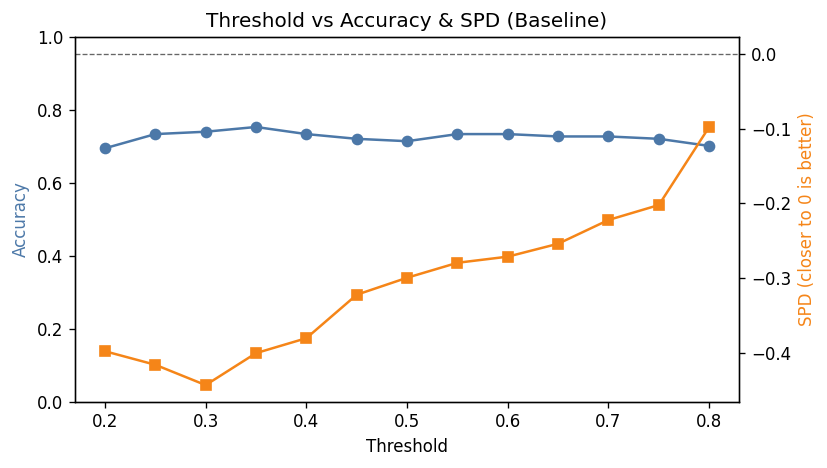

,threshold,accuracy,SPD
0,0.200,0.695,-0.397
1,0.250,0.734,-0.415
2,0.300,0.740,-0.442
3,0.350,0.753,-0.400
4,0.400,0.734,-0.380
5,0.450,0.721,-0.322
6,0.500,0.714,-0.299
7,0.550,0.734,-0.279
8,0.600,0.734,-0.271
9,0.650,0.727,-0.254


In [23]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from aif360.metrics import ClassificationMetric

thresholds = np.linspace(0.2, 0.8, 13)  # try thresholds from 0.2 to 0.8

def metrics_at_threshold(th):
    y_hat = (y_prob_base >= th).astype(int)
    pred_bld = test_bld.copy()
    pred_bld.labels = y_hat.reshape(-1, 1)
    cm = ClassificationMetric(
        test_bld, pred_bld,
        unprivileged_groups=[{'Age_group': 0}],
        privileged_groups=[{'Age_group': 1}]
    )
    return {
        "threshold": th,
        "accuracy": accuracy_score(y_test, y_hat),
        "SPD": cm.statistical_parity_difference(),
    }

sweep = pd.DataFrame([metrics_at_threshold(t) for t in thresholds])

# Plot Accuracy and SPD vs Threshold (two simple lines)
fig, ax1 = plt.subplots(figsize=(7,4), dpi=120)

ax1.plot(sweep["threshold"], sweep["accuracy"], marker="o", color="#4c78a8", label="Accuracy")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Accuracy", color="#4c78a8")
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
ax2.plot(sweep["threshold"], sweep["SPD"], marker="s", color="#f58518", label="SPD")
ax2.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.6)
ax2.set_ylabel("SPD (closer to 0 is better)", color="#f58518")

plt.title("Threshold vs Accuracy & SPD (Baseline)")
fig.tight_layout()
plt.show()

# Optional: show the table for quick reading
pd.set_option('display.float_format', lambda v: f"{v:.3f}")
display(sweep)


Move the threshold up/down to see how accuracy and SPD change.
